In [3]:
import torch
import torch.nn as nn
from ConvLstm import  ConvLSTM
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [4]:
# x = torch.rand((32, 10, 64, 128, 128))
# convlstm = ConvLSTM(64, 16, (3,3), 1, True, True, False)
# _, last_states = convlstm(x)
# h = last_states[0][0]  # 0 for layer index, 0 for h index

In [5]:
"""
Generate movies with 3 to 7 moving squares inside.
The squares are of shape 1x1 or 2x2 pixels, which move linearly over time.
For convenience we first create movies with bigger width and height (80x80) and at the end we select a 40x40 window.
reference: https://www.kaggle.com/code/kcostya/convlstm-convolutional-lstm-network-tutorial
"""

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [ ]:
noisy_movies, shifted_movies = generate_movies(n_samples=100)

In [7]:
noisy_movies.shape, shifted_movies.shape  # b, t, h, w, c

((100, 15, 40, 40, 1), (100, 15, 40, 40, 1))

In [8]:
num_epoch = 50         
lr = 0.005             
input_dim, hidden_dim, kernel_size, num_layers = 1, 1,(3,3),1
model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, True, True, False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_func = nn.CrossEntropyLoss()       
# 训练及测试
for epoch in range(num_epoch):
    model.train()
    train_loss = []
    for i, x in enumerate(noisy_movies):
        model.train()
        layer_output, last_states = model(torch.from_numpy(x).unsqueeze(0).permute(0, 1, 4, 2, 3).float()) # (15, 40, 40, 1)->(1, 15, 1, 40, 40)
        # h = last_states[0][0]  # 0 for layer index, 0 for h index  
        output = torch.sigmoid(layer_output[-1])     
        loss = loss_func(output, torch.from_numpy(shifted_movies[i]).unsqueeze(0).permute(0, 1, 4, 2, 3).float())
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [9]:
which = 90
track = noisy_movies[which]

In [10]:
track.shape

(15, 40, 40, 1)

In [11]:
last_states[0][0].shape

torch.Size([1, 1, 40, 40])

In [12]:
last_states[0][-1].permute(0, 1, 3,2).shape

torch.Size([1, 1, 40, 40])

In [13]:
model.eval()
for j in range(16):
    layer_output, last_states = model(torch.from_numpy(track).unsqueeze(0).permute(0, 1, 4, 2, 3).float()) # (1, 15, 40, 40, 1)
    new = torch.sigmoid(last_states[0][-1]).permute(0,2,3,1).detach().numpy() # (1, 40, 40, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

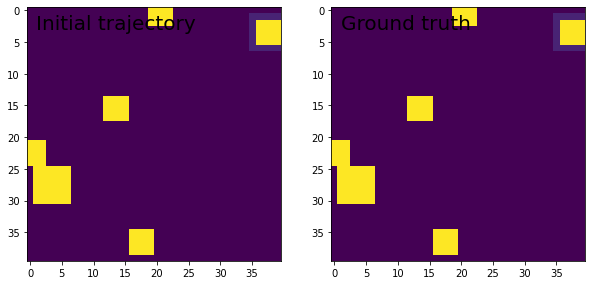

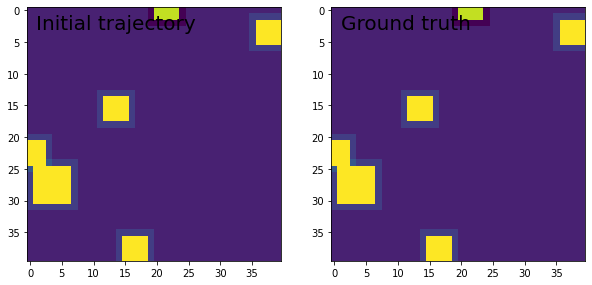

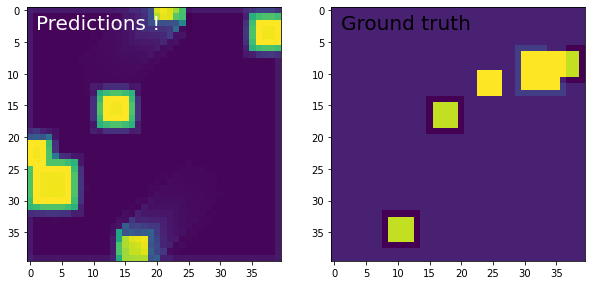

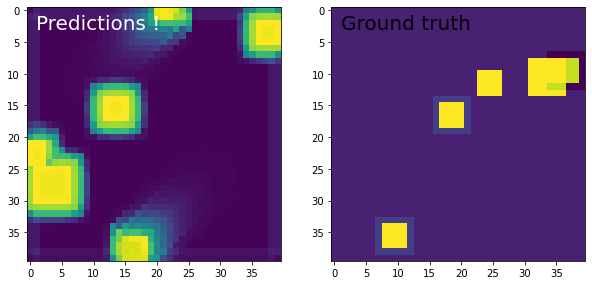

In [21]:
track2 = np.concatenate(noisy_movies[which:which+2][::, ::, ::, ::],axis=0)

for i in range(13,17,1):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 15:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))
